In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image

#np.random.seed(73)
%matplotlib inline

In [ ]:
# get the pictures with cells and types
!gdown 1WPnAm10cPH15nwoSxdyLQlNpJkbeW1Es
!gdown 1meMyqbtGLf6cTrjDArVMI9qbk65t9ulD

Downloading...
From: https://drive.google.com/uc?id=1WPnAm10cPH15nwoSxdyLQlNpJkbeW1Es
To: /content/types.png
100% 1.07k/1.07k [00:00<00:00, 1.50MB/s]
Downloading...
From: https://drive.google.com/uc?id=1meMyqbtGLf6cTrjDArVMI9qbk65t9ulD
To: /content/cells.png
100% 1.45k/1.45k [00:00<00:00, 2.23MB/s]




# Standard Potts model

$$ H = - J \sum \delta (\sigma_j, \sigma_j), $$


where $ J$ - interaction between neighbours, determines the adhesion between cells of different types;

$\sigma$ - cell ID;

$\delta$ - Kronecker delta;




In [ ]:
class PottsModel:
    def __init__(self):

        spins = np.asarray(Image.open('cells.png'))[:, :, 0]
        self.spins = spins.copy()
        self.N = len(spins)
        self.T = 10

    def get_neighbours(self, x, y):
        # extreme points 
        if x == 0:
            if y == 0:
                return np.array([[x + 1, y], [x, y + 1]])
            elif y == self.N - 1:
                return np.array([[x + 1, y], [x, y - 1]])
            else:
                return np.array([[x + 1, y], [x, y + 1], [x, y - 1]])

        elif y == 0:
            if x == 0:
                return np.array([[x + 1, y], [x, y + 1]])
            elif x == self.N - 1:
                return np.array([[x, y + 1], [x - 1, y]])
            else:
                return np.array([[x + 1, y], [x, y + 1], [x - 1, y]])        

        elif x == self.N - 1:
            if y == 0:
                return np.array([[x - 1, y], [x, y + 1]])
            elif y == self.N - 1:
                return np.array([[x - 1, y], [x, y - 1]])
            else:
                return np.array([[x - 1, y], [x, y + 1], [x, y - 1]])
        
        elif y == self.N - 1:
            if x == 0:
                return np.array([[x + 1, y], [x, y - 1]])
            elif x == self.N - 1:
                return np.array([[x - 1, y], [x, y - 1]])
            else:
                return np.array([[x - 1, y], [x + 1, y], [x, y - 1]])
        
        # other points
        else:
            return np.array([[x + 1, y], [x, y + 1],
                             [x - 1, y], [x ,y - 1]])   
        

    def k_delta(self, c_i, c_j):
        return float(c_i == c_j)

    
    def mc_standard(self):
        x = np.random.randint(low=0, high=self.N)
        y = np.random.randint(low=0, high=self.N)
        cell = self.spins[x, y]
        new_spin = np.random.choice(self.spins.flatten())

        h = []
        neighbours = self.get_neighbours(x, y)
        for i in neighbours:
            h.append(self.k_delta(self.spins[i[0], i[1]], new_spin))

        H = []
        for i in neighbours:
            H.append(self.k_delta(self.spins[i[0], i[1]], cell))

        dH = 2 * sum(H) - 2 * sum(h)
        #print(dH)

        if dH > 0:
            p = np.random.binomial(1, p=np.exp(-dH/self.T))
            if p == 1:
                self.spins[x, y] = new_spin.copy()
        else: 
            self.spins[x, y] = new_spin.copy()        


    def simulation(self, n_it):
        f = plt.figure(figsize=(17, 15), dpi=80);    
        self.plot_mc(f, self.spins, 0, self.N, 1);

        for i in range(n_it):

            self.mc_standard()

            if i == n_it // 5:     self.plot_mc(f, self.spins, i, self.N, 2);
            if i == n_it // 5 * 2: self.plot_mc(f, self.spins, i, self.N, 3);
            if i == n_it // 5 * 3: self.plot_mc(f, self.spins, i, self.N, 4);
            if i == n_it // 5 * 4: self.plot_mc(f, self.spins, i, self.N, 5);
            if i == n_it - 1:      self.plot_mc(f, self.spins, i, self.N, 6);
        return self.spins
     

    def plot_mc(self, f, config, i, N, n_):
        sp =  f.add_subplot(3, 3, n_ )  
        plt.imshow(config, cmap='gnuplot2', interpolation='none');
        plt.title('Time=%d'%i); plt.axis('tight')
        plt.colorbar()
    plt.show()


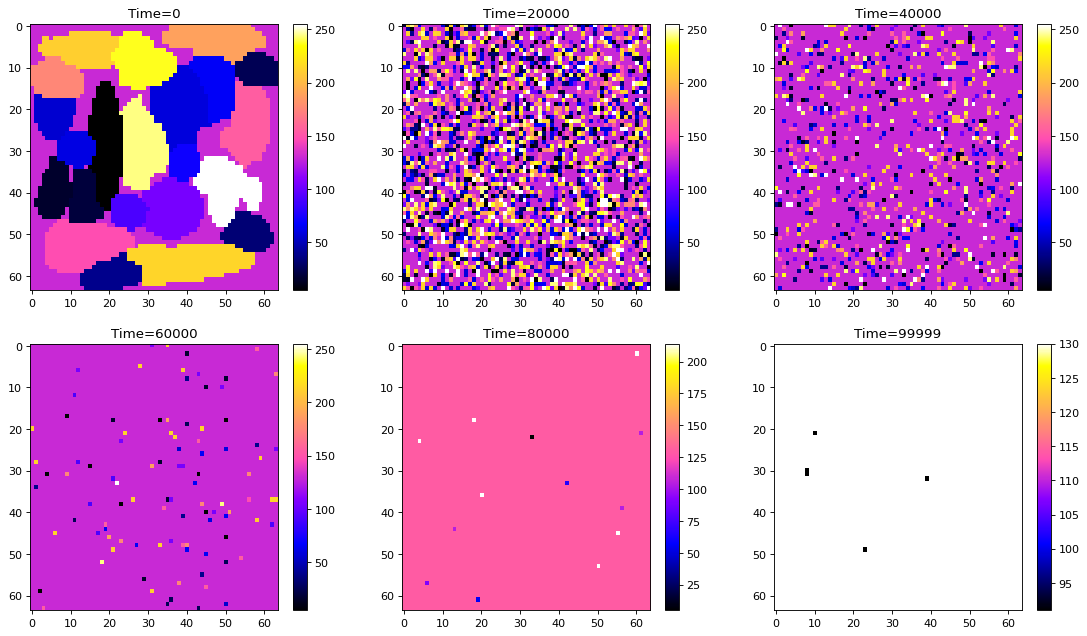

In [ ]:
pm = PottsModel()
_ = pm.simulation(100000)

Here everything disappeared, and only medium remained (medium spin = 130)

# Cellular Potts Model

$$ H = \sum J ( \tau (\sigma_i) \tau (\sigma_j)) (1 - \delta (\sigma_i, \sigma_j)) + \lambda \sum (v(\sigma_i) - V(\sigma_i))^2 \theta(V(\sigma_i)),$$

where $ J$ - interaction between neighbours, determines the adhesion between cells of different types;

$\sigma$ - cell ID;

$\delta$ - Kronecker delta;

$\tau(\sigma)$ - cell type;

$v(\sigma)$ - cell volume;

$V(\sigma)$ - target cell volume;

$\theta(x) = \{0: x < 0; 1: x>0\}$ - controls volume of medium;

$\lambda$ - strength of the volume constraint

In [ ]:
class CellularPottsModel:
    def __init__(self, lamb=1., T=10,):
        # cell ID is taken from 0 channel of picture
        spins = np.asarray(Image.open('cells.png'))[:, :, 0]
        types = np.asarray(Image.open('types.png'))[:, :, 0]

        # volume - number of pixels cell occupies
        self.volumes = Counter(list(spins.flatten()))
        self.cell_types = types.copy()
        self.spins = spins.copy()
    
        self.l = lamb
        self.T = T
        self.N = len(spins)
    

    def k_delta(self, c_i, c_j):
        return float(c_i == c_j)
    

    def adhesion(self, i_t, j_t):
        # dark cells
        if i_t == j_t == 0:
            return 2
        # light cells
        elif i_t == j_t == 255:
            return 14       
        elif (i_t == 0 and j_t == 255) or (i_t == 255 and j_t == 0):
            return 11        
        # medium
        elif j_t == 130 or i_t == 130:
            return 16        
        elif i_t == j_t:
            return 0
        
    
    def volume(self, cell):
        return np.sum(self.cell_types == cell) # self.volumes[cell]


    def target_volume(self, cell):
        vol = {130: 1020, 255: 1458, 0: 1618}
        if cell == 130:
            return -1 #* vol[cell]
        else:
            return vol[cell]
        

    def theta(self, t):
        return 1 if t > 0 else 0
    
    
    def get_neighbours(self, x, y):
        # extreme points 
        if x == 0:
            if y == 0:
                return np.array([[x + 1, y], [x, y + 1]])
            elif y == self.N - 1:
                return np.array([[x + 1, y], [x, y - 1]])
            else:
                return np.array([[x + 1, y], [x, y + 1], [x, y - 1]])

        elif y == 0:
            if x == 0:
                return np.array([[x + 1, y], [x, y + 1]])
            elif x == self.N - 1:
                return np.array([[x, y + 1], [x - 1, y]])
            else:
                return np.array([[x + 1, y], [x, y + 1], [x - 1, y]])        

        elif x == self.N - 1:
            if y == 0:
                return np.array([[x - 1, y], [x, y + 1]])
            elif y == self.N - 1:
                return np.array([[x - 1, y], [x, y - 1]])
            else:
                return np.array([[x - 1, y], [x, y + 1], [x, y - 1]])
        
        elif y == self.N - 1:
            if x == 0:
                return np.array([[x + 1, y], [x, y - 1]])
            elif x == self.N - 1:
                return np.array([[x - 1, y], [x, y - 1]])
            else:
                return np.array([[x - 1, y], [x + 1, y], [x, y - 1]])
        
        # other points
        else:
            return np.array([[x + 1, y], [x, y + 1],
                             [x - 1, y], [x ,y - 1]])
        
    
    def hamiltonian(self, cell, neighbour, cell_t, neighbour_t):
        return self.adhesion(cell_t, neighbour_t) * (1 - self.k_delta(cell, neighbour)) + \
               self.l * (self.volume(cell_t) - self.target_volume(cell_t)) **2 * \
               self.theta(self.target_volume(cell_t))
        

    def mc_cellular(self):

        x = np.random.randint(low=0, high=self.N)
        y = np.random.randint(low=0, high=self.N)
        cell = self.spins[x, y]
        cell_t = self.cell_types[x, y]

        # take random neighbour
        neighbours = self.get_neighbours(x, y)
        r_n = np.random.choice(list(range(len(neighbours))))
        neighbour = self.spins[neighbours[r_n][0], neighbours[r_n][1]]
        neighbour_t = self.cell_types[neighbours[r_n][0], neighbours[r_n][1]]
        
        # гамильтониан соседи и старый спин
        h = []
        for i in neighbours:
            # спин соседа
            n = self.spins[i[0], i[1]]
            # тип соседа
            n_t = self.cell_types[i[0], i[1]]

            h.append(self.hamiltonian(cell=cell, 
                                      neighbour=n, 
                                      cell_t=cell_t, 
                                      neighbour_t=n_t))
        # новый спин
        H = []
        for i in neighbours:
            # спин соседа
            n = self.spins[i[0], i[1]]
            # тип соседа
            n_t = self.cell_types[i[0], i[1]]

            H.append(self.hamiltonian(cell=neighbour, 
                                      neighbour=n, 
                                      cell_t=neighbour_t, 
                                      neighbour_t=n_t))

        dH = sum(h) - sum(H)
                

        if dH > 0:
            p = np.random.binomial(1, p=np.exp(-dH/self.T))
            if p == 1:
                self.spins[x, y] = neighbour.copy()
                self.cell_types[x, y] = neighbour_t.copy()

        else: 
            self.spins[x, y] = neighbour.copy()
            self.cell_types[x, y] = neighbour_t.copy()



    def simulation(self, n_it):
        f = plt.figure(figsize=(17, 15), dpi=80);    
        self.plot_mc(f, self.cell_types, 0, self.N, 1);

        for i in range(n_it):

            self.mc_cellular()

            if i == n_it // 5:     self.plot_mc(f, self.cell_types, i, self.N, 2);
            if i == n_it // 5 * 2: self.plot_mc(f, self.cell_types, i, self.N, 3);
            if i == n_it // 5 * 3: self.plot_mc(f, self.cell_types, i, self.N, 4);
            if i == n_it // 5 * 4: self.plot_mc(f, self.cell_types, i, self.N, 5);
            if i == n_it - 1:      self.plot_mc(f, self.cell_types, i, self.N, 6);
        return self.spins
    

    def plot_mc(self, f, config, i, N, n_):
        sp =  f.add_subplot(3, 3, n_ )  
        plt.imshow(config, cmap='gnuplot2');
        plt.title('Time=%d'%i); plt.axis('tight')
        plt.colorbar()
    plt.show()


### Lambda and T as it was proposed in the paper

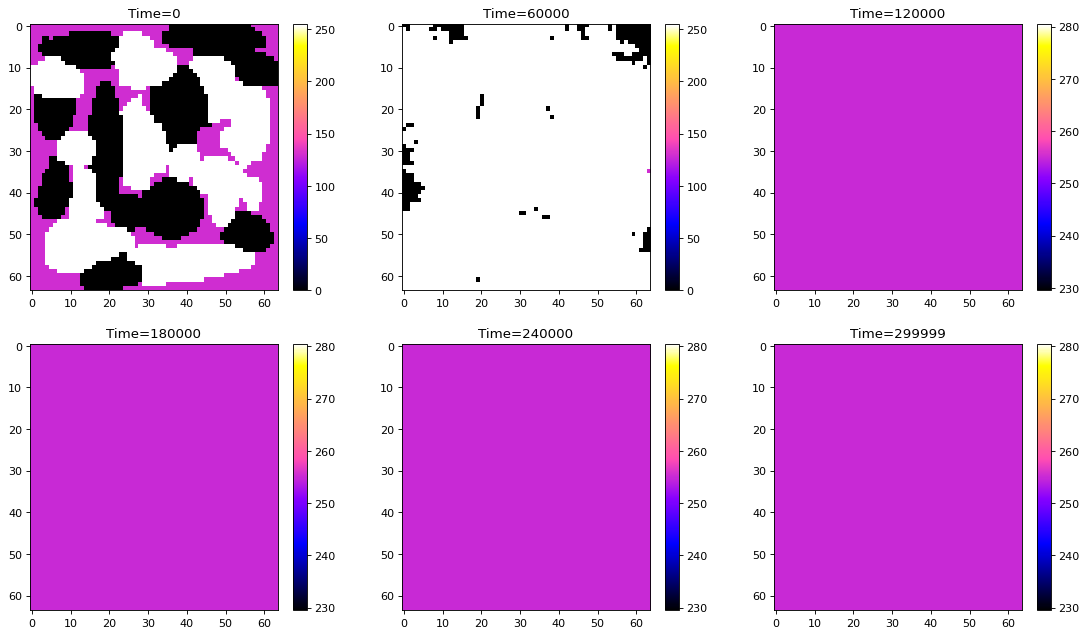

In [ ]:
cpm = CellularPottsModel(lamb=1, T=10)
sp = cpm.simulation(300000)

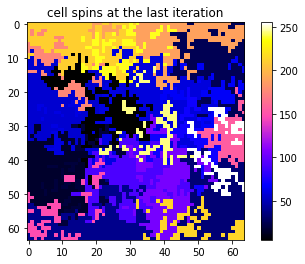

In [ ]:
plt.imshow(sp, cmap='gnuplot2')
plt.colorbar()

plt.title('cell spins at the last iteration');

### When lambda is smaller than temperature

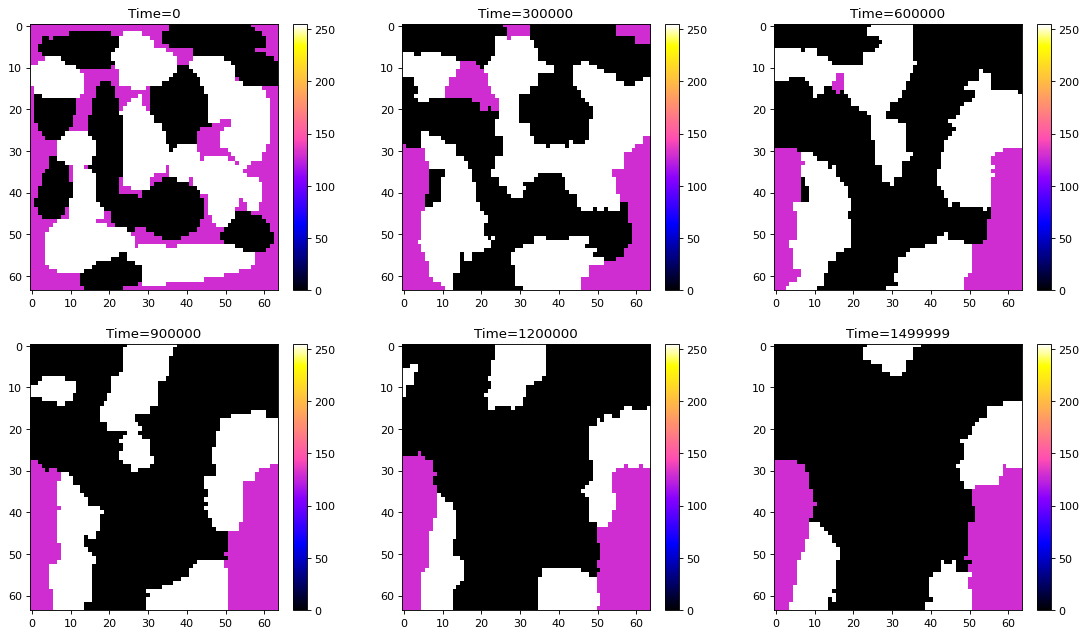

In [ ]:
cpm = CellularPottsModel(lamb=0.05, T=10)
sp = cpm.simulation(1500000)

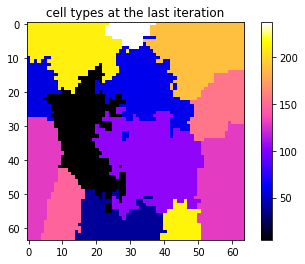

In [ ]:
plt.imshow(sp, cmap='gnuplot2')
plt.colorbar()
plt.title('cell types at the last iteration');

### When lambda is bigger than temperature

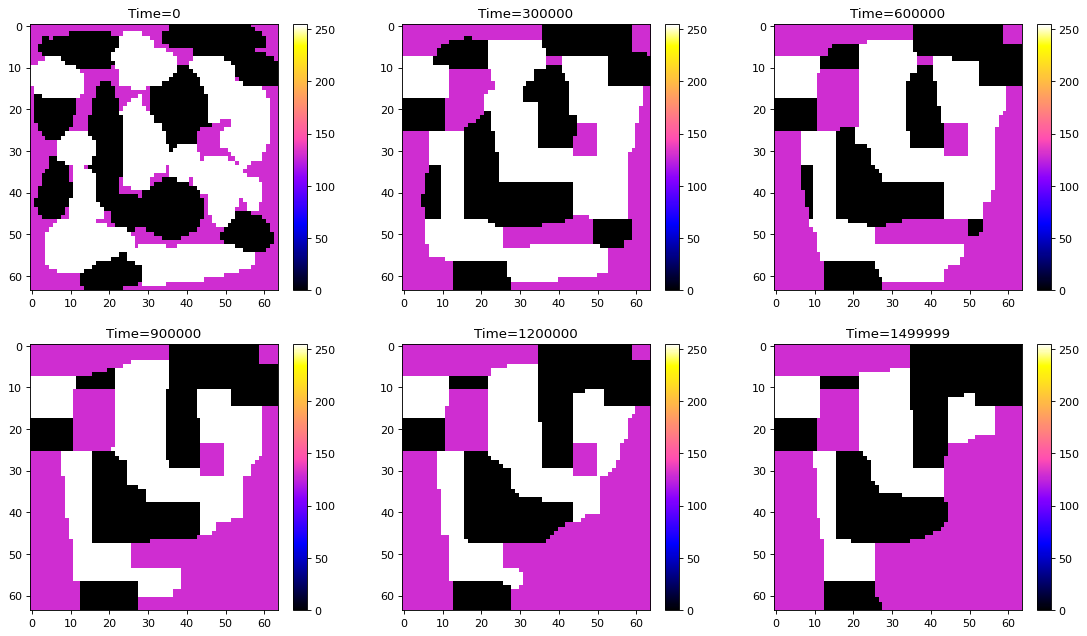

In [ ]:
cpm = CellularPottsModel(lamb=5, T=1)
sp = cpm.simulation(1500000)

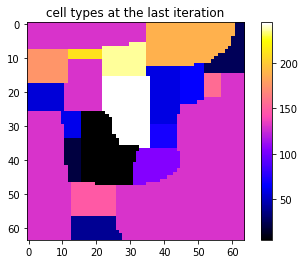

In [ ]:
plt.imshow(sp, cmap='gnuplot2')
plt.colorbar()
plt.title('cell types at the last iteration');